In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn.linear_model as sklm
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
import sklearn.linear_model
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso
from tqdm import tqdm_notebook
from itertools import combinations
%matplotlib inline

In [21]:
# основные константы
kb = 1.38064e-23 # постоянная Больцмана
T = 273.15 + 22 # температура в K
theta = np.pi/2 # угол рассеяния
n = 1.333 # показатель преломления
eta = 0.958e-3 # Н * с/м^2 - динамическая вязкость воды
l = 650e-9 # Длина волны лазера

coeff = 2*(kb * T/(3 * np.pi * eta)) * (4 * np.pi * n / l)**2 * np.sin(theta/2)**2
#типы частиц в растворе
d1 = 500e-9 #размер частицы в нм
d2 = 50e-9
w = 2.0*np.arange(1,5001) #спектр

def getTwoParticleI(w, d1, d2):
    G1 = coeff / d1 #Лоренц, соответствующий размеру d1
    G2 = coeff / d2
    y1 = G1 / ((2 * np.pi * w)**2 + G1**2)
    y2 = G2 / ((2 * np.pi * w)**2 + G2**2)
    y = y1 + y2
    return y

def getOneParticleI(w, d):
    G1 = coeff / d1 #Лоренц, соответствующий размеру d1
    y1 = G1 / ((2 * np.pi * w)**2 + G1**2)
    return y1

y = getTwoParticleI(w, d1, d2) #определяем полный спектр интенсивности для раствора с двумя сортами частиц

In [22]:
#исследуемый диапазон размеров частиц
# d_min = 1e-9 # 1 нм
# d_max = 1e-4 
# N = 256 # Число узлов в сетке по \Gamma

#сетка по \Gamma со сгущением к более крупным размерам
def getPowMesh(N, d_min, d_max):
    G = np.zeros(N)
    #диапазон Лоренцов, соответствующих минимальному и максимальному размерам
    G_min = coeff/d_max
    G_max = coeff/d_min
    #определяем сетку по ним
    p = (G_max/G_min)**(1/(N-1))
    for j in range(N):
        G[j] = G_min * (p**j)
    return G

#равномерная сетка по \Gamma
def getLinMesh(N, d_min, d_max):
    G_min = coeff/d_max
    G_max = coeff/d_min
    G = np.linspace(G_min, G_max, N)
    return G


# Матрица коэффициентов A переопределенной системы
def defineSystem(G, w):
    N = G.size
    M = w.size # Число точек по частоте
    A = np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            A[i,j] = G[j] / ((2 * np.pi * w[i])**2 + G[j]**2)
    return A

In [23]:
def LRsolve(A, y, G):
    # Ridge regression
    clf = sklm.Ridge(alpha = 5e-7)
    clf.fit(A, y)
    a1 = clf.coef_

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(3,1,1)
    line, = plt.plot(1e+9 * coeff/G, a1,'.-')
    ax.set_xscale('log')
    plt.xlim(1e9*d_min, 1e9*d_max)
    
    M = A.shape[0]
    
    # Non-negative ridge regression
    alpha = 1.3e-7
    B = np.zeros((M+N, N))
    B[0:M,:] = A
    B[M::, :] = alpha * np.eye(N)
    y_ = np.zeros(M+N)
    y_[0:M] = y
    a2, rnorm = scipy.optimize.nnls(B,y_)

    ax = plt.subplot(3,1,2)
    line, = plt.plot(1e+9 * coeff/G, a2,'.-')
    ax.set_xscale('log')
    plt.xlim(1e9*d_min, 1e9*d_max)

    # Lasso regression
    clf = sklm.LassoCV()
    clf.fit(A, y)
    a3 = clf.coef_

    # fig = plt.figure()
    ax = plt.subplot(3,1,3)
    line, = plt.plot(1e+9 * coeff/G, a3,'.-')
    ax.set_xscale('log')
    plt.xlim(1e9*d_min, 1e9*d_max)
    
    #print max particle size in nm
    i, = np.where( a1==max(a1) )
    print('Particle size in a1, nm = ', 1e+9*coeff/G[i])
    i, = np.where( a2==max(a2) )
    print('Particle size in a2, nm = ', 1e+9*coeff/G[i])
    i, = np.where( a3==max(a3) )
    print('Particle size in a3, nm = ', 1e+9*coeff/G[i])
    

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Particle size in a1, nm =  [ 50.80218047]
Particle size in a2, nm =  [ 50.80218047]
Particle size in a3, nm =  [ 60.85744643]


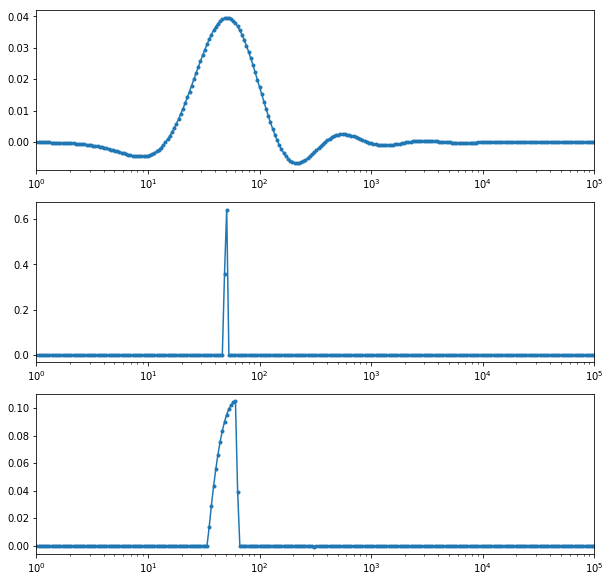

In [31]:
d_min = 1e-9 # 1 нм
d_max = 1e-4 
N = 256 # Число узлов в сетке по \Gamma

y = getTwoParticleI(w, 3e-15, 50e-09) 
# y = getOneParticleI(w, 50e-09) 
G = getPowMesh(N, d_min, d_max) #задем сетку
A = defineSystem(G, w) #определяем коэффициенты переопределенной системы
LRsolve(A, y, G) #решаем переопределенную систему

In [25]:
M = A.shape[0]

# Non-negative ridge regression
alpha = 1.3e-7
B = np.zeros((M+N, N))
B[0:M,:] = A
B[M::, :] = alpha * np.eye(N)
y_ = np.zeros(M+N)
y_[0:M] = y
a2, rnorm = scipy.optimize.nnls(B,y_)

(1.0, 100000.0)

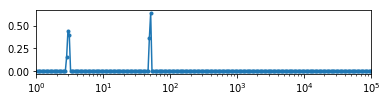

In [7]:
ax = plt.subplot(3,1,2)
line, = plt.plot(1e+9 * coeff/G, a2,'.-')
ax.set_xscale('log')
plt.xlim(1e9*d_min, 1e9*d_max)

----

In [8]:
def linear_model_fit(A, X_test_i):
    M = A.shape[0]
    N = A.shape[1]

    # Non-negative ridge regression
    alpha = 1.3e-7
    B = np.zeros((M+N, N))
    B[0:M,:] = A
    B[M::, :] = alpha * np.eye(N)
    y_ = np.zeros(M+N)
    y_[0:M] = X_test_i
    a2, rnorm = scipy.optimize.nnls(B,y_)
    
    return a2

In [10]:
d_min = 1e-9 # 1 нм
d_max = 5e-7

def linear_model_pred(X_test):
    G = getPowMesh(int(N_pred_dim), d_min, d_max) #задем сетку
    A = defineSystem(G, w) #определяем коэффициенты переопределенной системы
    lin_pred = []
    for i in tqdm_notebook(X_test):
        lin_pred.append(linear_model_fit(A, i))
    return np.array(lin_pred), G

# Сonstructing new dataset

In [11]:
import random

In [12]:
# основные константы
kb = 1.38064e-23 # постоянная Больцмана
T = 273.15 + 22 # температура в K
theta = np.pi/2 # угол рассеяния
n = 1.333 # показатель преломления
eta = 0.958e-3 # Н * с/м^2 - динамическая вязкость воды
l = 650e-9 # Длина волны лазера

coeff = 2*(kb * T/(3 * np.pi * eta)) * (4 * np.pi * n / l)**2 * np.sin(theta/2)**2

In [13]:
def getTwoParticleI(w, d1, d2):
    a1 = 1#random.random()
    a2 = 1#-a1
    if d1==d2:
        G1 = a1 * coeff / d1
        y1 = G1 / ((2 * np.pi * w)**2 + G1**2)
        return y1
    else:
        G1 = a1 * coeff / d1 #Лоренц, соответствующий размеру d1
        G2 = a2 * coeff / d2
        y1 = G1 / ((2 * np.pi * w)**2 + G1**2)
        y2 = G2 / ((2 * np.pi * w)**2 + G2**2)
        y = y1 + y2
        return y

def getNParticleI_NN(w, d):
    G = coeff /np.array(d)    
    all_x = [g_i/((2 * np.pi * w)**2 + g_i**2) for g_i in G]
    x = sum(all_x)
    return x

In [14]:
def get_mesh_lor(N, w_min=1, w_max=10**4): # получается сетка по частоте со сгущением в начале
    w = np.zeros(N)
    #определяем сетку по ним
    p = (w_max/w_min)**(1/(N-1))
    for j in range(N):
        w[j] = w_min * (p**j)
    return w

In [15]:
#исследуемый диапазон размеров частиц
d_min = 1e-9 # 1 нм
d_max = 3e-7
#Num_diam = 100
Num_diam = 300
pred_d = np.linspace(d_min,d_max, num = Num_diam)
#np.arange(d_min, d_max, shift)

In [16]:
N_pred_dim = pred_d.shape[0] # размерность предсказания

In [72]:
# Тут опрделяется размерность входа
Num_feat = 400
w = get_mesh_lor(Num_feat, w_min=1, w_max=10**4)

In [20]:
print ("Размерность предсказания:",N_pred_dim)

Размерность предсказания: 300


In [21]:
print ("Размерность входа:",w.shape[0])

Размерность входа: 400


In [112]:
w = np.load('new spectr/real_freq.npy')

In [113]:
w[::4].shape

(327,)

In [114]:
w = w[::4]

In [115]:
w.shape

(327,)

In [116]:
# генерируем датасет по массиву размеров частиц и сетке по частоте
def generate_dataset(d, w):
    X = []
    Y = []
    new_arr = np.array(d*10**9)
    new_arr = new_arr.astype('int64')
    for i ,j in combinations(range(d.shape[0]), 2):
        if (abs(i-j)<=1) \
        or (i>(d.shape[0]-2)) or (j>(d.shape[0]-2)):
            continue
        a = np.zeros_like(d)
        a[np.where(new_arr == np.int((d[i]*10**9)))[0][0]] = 1
        a[np.where(new_arr == np.int((d[j]*10**9)))[0][0]] = 1
        Y.append(a)
        X.append( getTwoParticleI(w,d[i],d[j]) )
    return np.array(X), np.array(Y)

In [117]:
X,Y = generate_dataset(pred_d,w)

In [118]:
import gc
gc.collect()

19798

In [119]:
X.shape

(44253, 327)

In [120]:
Y.shape

(44253, 300)

In [121]:
# # Let's make some noise
# X_ns = X + 0.005*X.mean(axis=1).reshape(X.shape[0],1)*np.random.normal(size = X.shape[1]).reshape(1,X.shape[1])

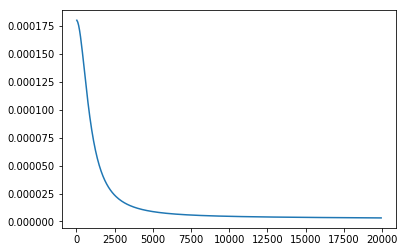

In [122]:
plt.plot(w, X[50])

### Model training

In [123]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from keras import backend
from sklearn.model_selection import train_test_split
from keras import regularizers
from scipy.signal import argrelextrema
from keras.callbacks import ModelCheckpoint

In [124]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [125]:
# Делим на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Linear model

In [126]:
def linear_model_fit(A, X_test_i):
    M = A.shape[0]
    N = A.shape[1]

    # Non-negative ridge regression
    alpha = 1.3e-7
    B = np.zeros((M+N, N))
    B[0:M,:] = A
    B[M::, :] = alpha * np.eye(N)
    y_ = np.zeros(M+N)
    y_[0:M] = X_test_i
    a2, rnorm = scipy.optimize.nnls(B,y_)
    
    return a2

In [127]:
w.shape

(327,)

In [128]:
X[0].shape

(327,)

In [129]:
# функция возращает предсказание линейной модели
def linear_model_pred(X_test,w):
    G = getPowMesh(int(N_pred_dim), d_min, d_max) #задем сетку
    A = defineSystem(G, w) #определяем коэффициенты переопределенной системы
    lin_pred = []
    for i in tqdm_notebook(X_test):
        lin_pred.append(linear_model_fit(A, i))
    return np.array(lin_pred), G

In [130]:
def rmse_on_mean_dim_for_linear(y_pred, y_test):
    d_pr = coeff/G[np.argmax(y_pred,axis=1)]
    d_tr = pred_d[np.argmax(y_test,axis=1)]
    return np.sqrt(np.mean((d_pr - d_tr)**2))

In [92]:
linear_pred,G = linear_model_pred(X_test, w)

KeyboardInterrupt: 

In [64]:
print('Mean square error is',rmse_on_mean_dim_for_linear(linear_pred,y_test))

Mean square error is 1.22550834434e-07


In [65]:
point= 100

(1.0, 300.0)

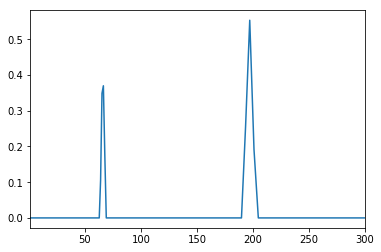

In [66]:
plt.plot(1e+9 * coeff/G, linear_pred[point])
plt.xlim(1e9*d_min, 1e9*d_max)

# Stacking

In [131]:
linear_pred_for_tr,G = linear_model_pred(X_train, w)

In [132]:
filepath = 'weights/several_part_best.hdf5'

In [133]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1]+linear_pred_for_tr.shape[1], kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(256,  kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dense(Y.shape[1], kernel_initializer='normal'))
model.add(Activation('relu'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics = [rmse])
checkpoint = ModelCheckpoint(filepath, monitor='rmse', verbose=1, save_best_only=True, mode='min')

In [134]:
# обьединяем предсказание линейной модели и данных
new_train = np.hstack([X_train, linear_pred_for_tr])

In [143]:
new_train.shape

(29649, 627)

In [144]:
linear_pred_for_tr.shape

(29649, 300)

In [145]:
X_train.shape

(29649, 327)

In [150]:
history = model.fit(new_train, y_train, epochs=50, batch_size=50, verbose=2, callbacks = [checkpoint])

Epoch 1/50
Epoch 00000: rmse improved from 0.06538 to 0.06537, saving model to weights/several_part_best.hdf5
3s - loss: 0.0047 - rmse: 0.0654
Epoch 2/50
Epoch 00001: rmse improved from 0.06537 to 0.06530, saving model to weights/several_part_best.hdf5
3s - loss: 0.0047 - rmse: 0.0653
Epoch 3/50


KeyboardInterrupt: 

In [151]:
model.load_weights('weights/several_part_best.hdf5')

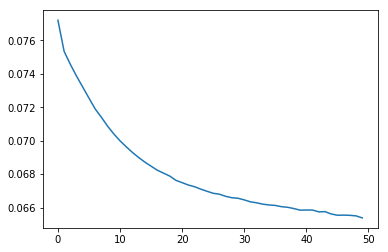

In [139]:
pyplot.plot(history.history['rmse'])
pyplot.show()

In [136]:
# делаем предсказание
linear_pred_for_test,G = linear_model_pred(X_test,w)
new_test = np.hstack([X_test, linear_pred_for_test])
y_pred = model.predict(new_test)

In [99]:
# эта функция считаемт rmse но рассчитана только на одночастичный случай
def rmse_on_max_d(y_pred, y_test):
    d_pr = pred_d[np.argmax(y_pred,axis=1)]
    d_tr = pred_d[np.argmax(y_test,axis=1)]
    return np.sqrt(np.mean((d_pr - d_tr)**2))

In [140]:
print('mean square error of nn is',rmse_on_max_d(y_pred, y_test))

mean square error of nn is 1.00066891487e-07


In [138]:
print('mean square error of nn is',rmse_on_max_d(y_pred, y_test))

mean square error of nn is 1.00066891487e-07


### Visualization 

In [102]:
def plot_and_predict(point, d=pred_d):
    plt.title('Spectrum of intensity')
    plt.plot(w, X_test[point])
    plt.xlabel('Frequency')
    plt.ylabel('Intensity')
    plt.show()
    
    plt.title('Real distribution')
    plt.plot(d, y_test[point])
    plt.xlabel('Diameter of particles')
    plt.ylabel('Concentration')
    plt.show()
    print("Точки (нм):", d[np.where(y_test[point] == 1)]*10**9)
    print ("Расстояние между ними (нм) = ",np.diff(d[np.where(y_test[point] == 1)])*10**9 )
    
    plt.title('Prediction of NN')
    plt.plot(d, y_pred[point])
    plt.xlabel('Diameter of particles')
    plt.ylabel('Concentration')
    plt.show()
    print("Точки (нм):", d[argrelextrema(y_pred[point], np.greater)]*10**9)
    print ("Точки (нм), с отбором",d[find_points(y_pred, point)]*10**9)
    print ("Расстояние между ними (нм) = ",np.diff(d[argrelextrema(y_pred[point], np.greater)])*10**9 )
    
    plt.plot( coeff/G, linear_pred_for_test[point])
    plt.xlabel('Diameter of particles')
    plt.ylabel('Concentration')
    plt.title('Prediction of Linear Model')
    plt.show()
    print("Точки (нм):", d[argrelextrema(linear_pred_for_test[point], np.greater)]*10**9)
    print ("Расстояние между ними (нм) = ",np.diff(d[argrelextrema(linear_pred_for_test[point], np.greater)])*10**9 )

831 912 294 1 735 924

In [103]:
def find_points(y_pred, point):
    extrm = argrelextrema(y_pred[point], np.greater)[0]
    need_point = []
    for i in extrm:
        if y_pred[point][i] > 0.25:
            need_point.append(i)
    return need_point

In [104]:
def rmse_on_extrmums(y_pred, y_test):
    result_array = []
    for point in range(y_pred.shape[0]):
        
        pred_diams = np.array(find_points(y_pred, point))
        real_diams = np.array(pred_d[np.where(y_test[point] == 1)]*10**9)
        
        if pred_diams.shape[0] != real_diams.shape[0]:
            print ("Wrong number prediction, point: ",point)
            general_shape = min(pred_diams.shape[0], real_diams.shape[0])
            if (general_shape == 0):
                continue
            result_array.append( np.sqrt(np.mean((pred_diams[:general_shape] - real_diams[:general_shape])**2)) )
        else:
            result_array.append( np.sqrt(np.mean((pred_diams - real_diams)**2)) )
        #result_array.append(np.sqrt(np.mean((d_pr - d_tr)**2)))
        
    return result_array

In [53]:
metric = rmse_on_extrmums(y_pred, y_test)

Wrong number prediction, point:  0
Wrong number prediction, point:  2
Wrong number prediction, point:  3
Wrong number prediction, point:  4
Wrong number prediction, point:  5
Wrong number prediction, point:  6
Wrong number prediction, point:  8
Wrong number prediction, point:  10
Wrong number prediction, point:  11
Wrong number prediction, point:  12
Wrong number prediction, point:  16
Wrong number prediction, point:  20
Wrong number prediction, point:  21
Wrong number prediction, point:  22
Wrong number prediction, point:  25
Wrong number prediction, point:  27
Wrong number prediction, point:  28
Wrong number prediction, point:  29
Wrong number prediction, point:  30
Wrong number prediction, point:  32
Wrong number prediction, point:  33
Wrong number prediction, point:  35
Wrong number prediction, point:  36
Wrong number prediction, point:  37
Wrong number prediction, point:  38
Wrong number prediction, point:  39
Wrong number prediction, point:  40
Wrong number prediction, point:  41

Wrong number prediction, point:  778
Wrong number prediction, point:  779
Wrong number prediction, point:  780
Wrong number prediction, point:  782
Wrong number prediction, point:  783
Wrong number prediction, point:  785
Wrong number prediction, point:  787
Wrong number prediction, point:  788
Wrong number prediction, point:  789
Wrong number prediction, point:  790
Wrong number prediction, point:  791
Wrong number prediction, point:  792
Wrong number prediction, point:  793
Wrong number prediction, point:  794
Wrong number prediction, point:  795
Wrong number prediction, point:  796
Wrong number prediction, point:  797
Wrong number prediction, point:  799
Wrong number prediction, point:  802
Wrong number prediction, point:  804
Wrong number prediction, point:  807
Wrong number prediction, point:  808
Wrong number prediction, point:  809
Wrong number prediction, point:  811
Wrong number prediction, point:  812
Wrong number prediction, point:  813
Wrong number prediction, point:  814
W

Wrong number prediction, point:  1596
Wrong number prediction, point:  1598
Wrong number prediction, point:  1600
Wrong number prediction, point:  1601
Wrong number prediction, point:  1602
Wrong number prediction, point:  1603
Wrong number prediction, point:  1605
Wrong number prediction, point:  1607
Wrong number prediction, point:  1608
Wrong number prediction, point:  1609
Wrong number prediction, point:  1610
Wrong number prediction, point:  1611
Wrong number prediction, point:  1612
Wrong number prediction, point:  1613
Wrong number prediction, point:  1614
Wrong number prediction, point:  1615
Wrong number prediction, point:  1616
Wrong number prediction, point:  1617
Wrong number prediction, point:  1618
Wrong number prediction, point:  1619
Wrong number prediction, point:  1620
Wrong number prediction, point:  1621
Wrong number prediction, point:  1622
Wrong number prediction, point:  1623
Wrong number prediction, point:  1624
Wrong number prediction, point:  1625
Wrong number

Wrong number prediction, point:  2485
Wrong number prediction, point:  2486
Wrong number prediction, point:  2487
Wrong number prediction, point:  2489
Wrong number prediction, point:  2490
Wrong number prediction, point:  2492
Wrong number prediction, point:  2493
Wrong number prediction, point:  2494
Wrong number prediction, point:  2495
Wrong number prediction, point:  2496
Wrong number prediction, point:  2497
Wrong number prediction, point:  2498
Wrong number prediction, point:  2499
Wrong number prediction, point:  2501
Wrong number prediction, point:  2502
Wrong number prediction, point:  2505
Wrong number prediction, point:  2506
Wrong number prediction, point:  2508
Wrong number prediction, point:  2509
Wrong number prediction, point:  2510
Wrong number prediction, point:  2513
Wrong number prediction, point:  2514
Wrong number prediction, point:  2515
Wrong number prediction, point:  2517
Wrong number prediction, point:  2518
Wrong number prediction, point:  2521
Wrong number

Wrong number prediction, point:  3548
Wrong number prediction, point:  3549
Wrong number prediction, point:  3550
Wrong number prediction, point:  3552
Wrong number prediction, point:  3553
Wrong number prediction, point:  3554
Wrong number prediction, point:  3555
Wrong number prediction, point:  3556
Wrong number prediction, point:  3557
Wrong number prediction, point:  3558
Wrong number prediction, point:  3559
Wrong number prediction, point:  3560
Wrong number prediction, point:  3561
Wrong number prediction, point:  3562
Wrong number prediction, point:  3563
Wrong number prediction, point:  3564
Wrong number prediction, point:  3565
Wrong number prediction, point:  3566
Wrong number prediction, point:  3567
Wrong number prediction, point:  3568
Wrong number prediction, point:  3571
Wrong number prediction, point:  3572
Wrong number prediction, point:  3573
Wrong number prediction, point:  3575
Wrong number prediction, point:  3576
Wrong number prediction, point:  3578
Wrong number

Wrong number prediction, point:  4684
Wrong number prediction, point:  4686
Wrong number prediction, point:  4687
Wrong number prediction, point:  4690
Wrong number prediction, point:  4692
Wrong number prediction, point:  4693
Wrong number prediction, point:  4694
Wrong number prediction, point:  4695
Wrong number prediction, point:  4696
Wrong number prediction, point:  4697
Wrong number prediction, point:  4698
Wrong number prediction, point:  4699
Wrong number prediction, point:  4700
Wrong number prediction, point:  4701
Wrong number prediction, point:  4702
Wrong number prediction, point:  4703
Wrong number prediction, point:  4704
Wrong number prediction, point:  4705
Wrong number prediction, point:  4706
Wrong number prediction, point:  4707
Wrong number prediction, point:  4709
Wrong number prediction, point:  4710
Wrong number prediction, point:  4712
Wrong number prediction, point:  4713
Wrong number prediction, point:  4715
Wrong number prediction, point:  4717
Wrong number

Wrong number prediction, point:  5788
Wrong number prediction, point:  5789
Wrong number prediction, point:  5790
Wrong number prediction, point:  5792
Wrong number prediction, point:  5793
Wrong number prediction, point:  5794
Wrong number prediction, point:  5796
Wrong number prediction, point:  5797
Wrong number prediction, point:  5798
Wrong number prediction, point:  5799
Wrong number prediction, point:  5800
Wrong number prediction, point:  5802
Wrong number prediction, point:  5803
Wrong number prediction, point:  5805
Wrong number prediction, point:  5807
Wrong number prediction, point:  5808
Wrong number prediction, point:  5809
Wrong number prediction, point:  5810
Wrong number prediction, point:  5812
Wrong number prediction, point:  5813
Wrong number prediction, point:  5814
Wrong number prediction, point:  5815
Wrong number prediction, point:  5817
Wrong number prediction, point:  5818
Wrong number prediction, point:  5820
Wrong number prediction, point:  5821
Wrong number

Wrong number prediction, point:  6913
Wrong number prediction, point:  6914
Wrong number prediction, point:  6915
Wrong number prediction, point:  6916
Wrong number prediction, point:  6917
Wrong number prediction, point:  6918
Wrong number prediction, point:  6919
Wrong number prediction, point:  6920
Wrong number prediction, point:  6921
Wrong number prediction, point:  6922
Wrong number prediction, point:  6923
Wrong number prediction, point:  6924
Wrong number prediction, point:  6925
Wrong number prediction, point:  6926
Wrong number prediction, point:  6928
Wrong number prediction, point:  6929
Wrong number prediction, point:  6930
Wrong number prediction, point:  6931
Wrong number prediction, point:  6932
Wrong number prediction, point:  6933
Wrong number prediction, point:  6935
Wrong number prediction, point:  6936
Wrong number prediction, point:  6937
Wrong number prediction, point:  6938
Wrong number prediction, point:  6939
Wrong number prediction, point:  6940
Wrong number

Wrong number prediction, point:  8021
Wrong number prediction, point:  8024
Wrong number prediction, point:  8025
Wrong number prediction, point:  8026
Wrong number prediction, point:  8027
Wrong number prediction, point:  8028
Wrong number prediction, point:  8030
Wrong number prediction, point:  8032
Wrong number prediction, point:  8033
Wrong number prediction, point:  8034
Wrong number prediction, point:  8035
Wrong number prediction, point:  8036
Wrong number prediction, point:  8038
Wrong number prediction, point:  8039
Wrong number prediction, point:  8041
Wrong number prediction, point:  8043
Wrong number prediction, point:  8044
Wrong number prediction, point:  8045
Wrong number prediction, point:  8046
Wrong number prediction, point:  8047
Wrong number prediction, point:  8048
Wrong number prediction, point:  8049
Wrong number prediction, point:  8051
Wrong number prediction, point:  8052
Wrong number prediction, point:  8053
Wrong number prediction, point:  8055
Wrong number

Wrong number prediction, point:  9002
Wrong number prediction, point:  9003
Wrong number prediction, point:  9004
Wrong number prediction, point:  9005
Wrong number prediction, point:  9006
Wrong number prediction, point:  9007
Wrong number prediction, point:  9008
Wrong number prediction, point:  9009
Wrong number prediction, point:  9010
Wrong number prediction, point:  9011
Wrong number prediction, point:  9012
Wrong number prediction, point:  9013
Wrong number prediction, point:  9014
Wrong number prediction, point:  9015
Wrong number prediction, point:  9016
Wrong number prediction, point:  9018
Wrong number prediction, point:  9019
Wrong number prediction, point:  9021
Wrong number prediction, point:  9022
Wrong number prediction, point:  9024
Wrong number prediction, point:  9025
Wrong number prediction, point:  9026
Wrong number prediction, point:  9027
Wrong number prediction, point:  9029
Wrong number prediction, point:  9030
Wrong number prediction, point:  9031
Wrong number

Wrong number prediction, point:  10131
Wrong number prediction, point:  10132
Wrong number prediction, point:  10133
Wrong number prediction, point:  10135
Wrong number prediction, point:  10136
Wrong number prediction, point:  10137
Wrong number prediction, point:  10138
Wrong number prediction, point:  10139
Wrong number prediction, point:  10140
Wrong number prediction, point:  10141
Wrong number prediction, point:  10142
Wrong number prediction, point:  10143
Wrong number prediction, point:  10147
Wrong number prediction, point:  10149
Wrong number prediction, point:  10151
Wrong number prediction, point:  10153
Wrong number prediction, point:  10154
Wrong number prediction, point:  10155
Wrong number prediction, point:  10156
Wrong number prediction, point:  10158
Wrong number prediction, point:  10159
Wrong number prediction, point:  10160
Wrong number prediction, point:  10162
Wrong number prediction, point:  10164
Wrong number prediction, point:  10165
Wrong number prediction, 

Wrong number prediction, point:  11235
Wrong number prediction, point:  11236
Wrong number prediction, point:  11237
Wrong number prediction, point:  11238
Wrong number prediction, point:  11239
Wrong number prediction, point:  11240
Wrong number prediction, point:  11241
Wrong number prediction, point:  11243
Wrong number prediction, point:  11244
Wrong number prediction, point:  11247
Wrong number prediction, point:  11249
Wrong number prediction, point:  11250
Wrong number prediction, point:  11251
Wrong number prediction, point:  11252
Wrong number prediction, point:  11254
Wrong number prediction, point:  11255
Wrong number prediction, point:  11256
Wrong number prediction, point:  11257
Wrong number prediction, point:  11258
Wrong number prediction, point:  11259
Wrong number prediction, point:  11262
Wrong number prediction, point:  11263
Wrong number prediction, point:  11264
Wrong number prediction, point:  11265
Wrong number prediction, point:  11267
Wrong number prediction, 

Wrong number prediction, point:  12276
Wrong number prediction, point:  12277
Wrong number prediction, point:  12278
Wrong number prediction, point:  12280
Wrong number prediction, point:  12281
Wrong number prediction, point:  12282
Wrong number prediction, point:  12284
Wrong number prediction, point:  12285
Wrong number prediction, point:  12286
Wrong number prediction, point:  12287
Wrong number prediction, point:  12288
Wrong number prediction, point:  12289
Wrong number prediction, point:  12290
Wrong number prediction, point:  12291
Wrong number prediction, point:  12293
Wrong number prediction, point:  12294
Wrong number prediction, point:  12295
Wrong number prediction, point:  12296
Wrong number prediction, point:  12297
Wrong number prediction, point:  12299
Wrong number prediction, point:  12300
Wrong number prediction, point:  12301
Wrong number prediction, point:  12302
Wrong number prediction, point:  12304
Wrong number prediction, point:  12305
Wrong number prediction, 

Wrong number prediction, point:  13390
Wrong number prediction, point:  13391
Wrong number prediction, point:  13392
Wrong number prediction, point:  13393
Wrong number prediction, point:  13395
Wrong number prediction, point:  13396
Wrong number prediction, point:  13397
Wrong number prediction, point:  13398
Wrong number prediction, point:  13399
Wrong number prediction, point:  13400
Wrong number prediction, point:  13401
Wrong number prediction, point:  13402
Wrong number prediction, point:  13403
Wrong number prediction, point:  13405
Wrong number prediction, point:  13406
Wrong number prediction, point:  13407
Wrong number prediction, point:  13409
Wrong number prediction, point:  13410
Wrong number prediction, point:  13411
Wrong number prediction, point:  13412
Wrong number prediction, point:  13413
Wrong number prediction, point:  13414
Wrong number prediction, point:  13415
Wrong number prediction, point:  13416
Wrong number prediction, point:  13417
Wrong number prediction, 

Wrong number prediction, point:  14406
Wrong number prediction, point:  14407
Wrong number prediction, point:  14410
Wrong number prediction, point:  14412
Wrong number prediction, point:  14414
Wrong number prediction, point:  14415
Wrong number prediction, point:  14416
Wrong number prediction, point:  14418
Wrong number prediction, point:  14419
Wrong number prediction, point:  14420
Wrong number prediction, point:  14422
Wrong number prediction, point:  14423
Wrong number prediction, point:  14424
Wrong number prediction, point:  14425
Wrong number prediction, point:  14426
Wrong number prediction, point:  14427
Wrong number prediction, point:  14428
Wrong number prediction, point:  14429
Wrong number prediction, point:  14430
Wrong number prediction, point:  14432
Wrong number prediction, point:  14433
Wrong number prediction, point:  14435
Wrong number prediction, point:  14436
Wrong number prediction, point:  14437
Wrong number prediction, point:  14438
Wrong number prediction, 

In [54]:
np.array(metric).shape

(10077,)

In [55]:
metric

[32.000000000000028,
 1.5811388300841627,
 77.000000000000028,
 43.000000000000014,
 0.99999999999998579,
 0.99999999999997868,
 0.99999999999998579,
 1.9999999999999991,
 69.000000000000057,
 0.99999999999998579,
 0.99999999999999289,
 0.70710678118652748,
 0.99999999999999911,
 0.99999999999999289,
 0.99999999999997158,
 13.453624047073731,
 35.418921496849677,
 17.691806012954174,
 178.0,
 1.5811388300841807,
 218.0,
 131.0,
 0.99999999999997158,
 0.99999999999995737,
 0.99999999999997158,
 91.000000000000028,
 1.0,
 1.0,
 1.9999999999999716,
 56.000000000000028,
 28.000000000000028,
 155.0,
 93.0,
 61.000000000000028,
 0.99999999999997868,
 207.0,
 0.99999999999998224,
 1.4142135623730749,
 0.99999999999998579,
 66.000000000000028,
 16.000000000000028,
 177.0,
 1.5811388300841851,
 132.00000000000003,
 2.2360679774997645,
 19.000000000000028,
 0.99999999999997868,
 180.0,
 1.0,
 0.99999999999999289,
 92.000000000000014,
 1.9999999999999716,
 0.99999999999997158,
 168.0,
 62.0000000

In [56]:
np.array(metric).mean()

36.038032378949239

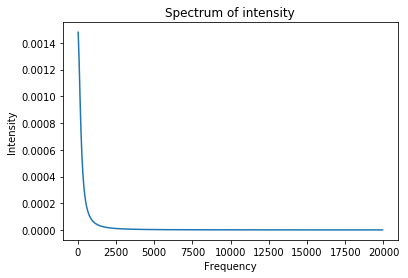

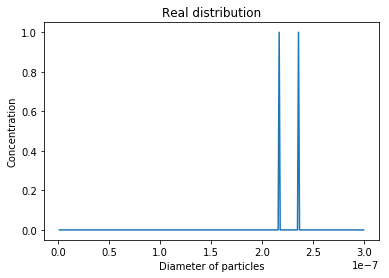

Точки (нм): [ 217.  236.]
Расстояние между ними (нм) =  [ 19.]


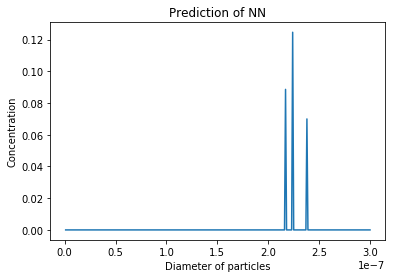

Точки (нм): [ 217.  224.  238.]
Точки (нм), с отбором []
Расстояние между ними (нм) =  [  7.  14.]


IndexError: index 150 is out of bounds for axis 0 with size 1

In [177]:
plot_and_predict(150)

In [170]:
# тут просто берется какя то частица и проверяется 
# как отрабатывает сеть
try_particle_size = 200
X_try = getNParticleI_NN(w,[try_particle_size*1e-9])
y_try = np.zeros(300)
y_try[try_particle_size] = 1

In [171]:
linear_pred_for_test,G = linear_model_pred([X_try],w)
new_test = np.hstack([[X_try], linear_pred_for_test])

In [172]:
y_pred_try = model.predict(new_test)

In [173]:
def find_points(y_pred, point):
    extrm = argrelextrema(y_pred[point], np.greater)[0]
    need_point = []
    for i in extrm:
        if y_pred[point][i] > 0.25:
            need_point.append(i)
    return need_point

In [174]:
find_points(y_pred_try, 0)

[]

In [175]:
find_points([y_try], 0)

[200]